<a href="https://colab.research.google.com/github/marco-siino/Agentic-ORAN-LLM/blob/main/A_LLM_Versions_Comparison_EnergyCrisisSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A-LLM versions comparison.

# Installazione librerie

In [1]:
!pip install mistralai gymnasium stable-baselines3 shimmy pandas matplotlib

INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.2/478.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: opentelemetry-proto
    Found existing installation: opentelemetry-proto 1.37.0
    Uninstalling opentelemetry-proto-1.37.0:
      Successfully uninstalled opentelemetry-proto-1.37.0
  Attempting uninstall: opentelemetry-exporter-otlp-proto-common
    Found existi

# Esperimenti finali Paper


📸 SNAPSHOT STEP 26 | Context: Price=1.26x

🤖 MODEL: OPEN-MISTRAL-7B
------------------------------------------------------------
  📍 CELL 1 [Load: 54% | Safety: 0.0]
     LLM Output:  {"w_thr": 0.05, "w_eng": 0.9, "w_safe": 0.05}
     -> Weights:  Thr=0.05, Eng=0.90, Safe=0.05
     -> Action:   Power=12.9W
  📍 CELL 2 [Load: 60% | Safety: 100.0]
     LLM Output:  {"w_thr": 0.0, "w_eng": 0.0, "w_safe": 1.0}
     -> Weights:  Thr=0.00, Eng=0.00, Safe=1.00
     -> Action:   Power=60.0W
  📍 CELL 3 [Load: 69% | Safety: 0.0]
     LLM Output:  {"w_thr": 0.1, "w_eng": 0.8, "w_safe": 0.1}
     -> Weights:  Thr=0.10, Eng=0.80, Safe=0.10
     -> Action:   Power=39.8W

🤖 MODEL: MISTRAL-SMALL-LATEST
------------------------------------------------------------
  📍 CELL 1 [Load: 54% | Safety: 0.0]
     LLM Output:  {
  "w_thr": 0.46,
  "w_eng": 0.54,
  "w_safe": 0.0
}
     -> Weights:  Thr=0.46, Eng=0.54, Safe=0.00
     -> Action:   Power=38.7W
  📍 CELL 2 [Load: 60% | Safety: 100.0]
     LLM Output: 

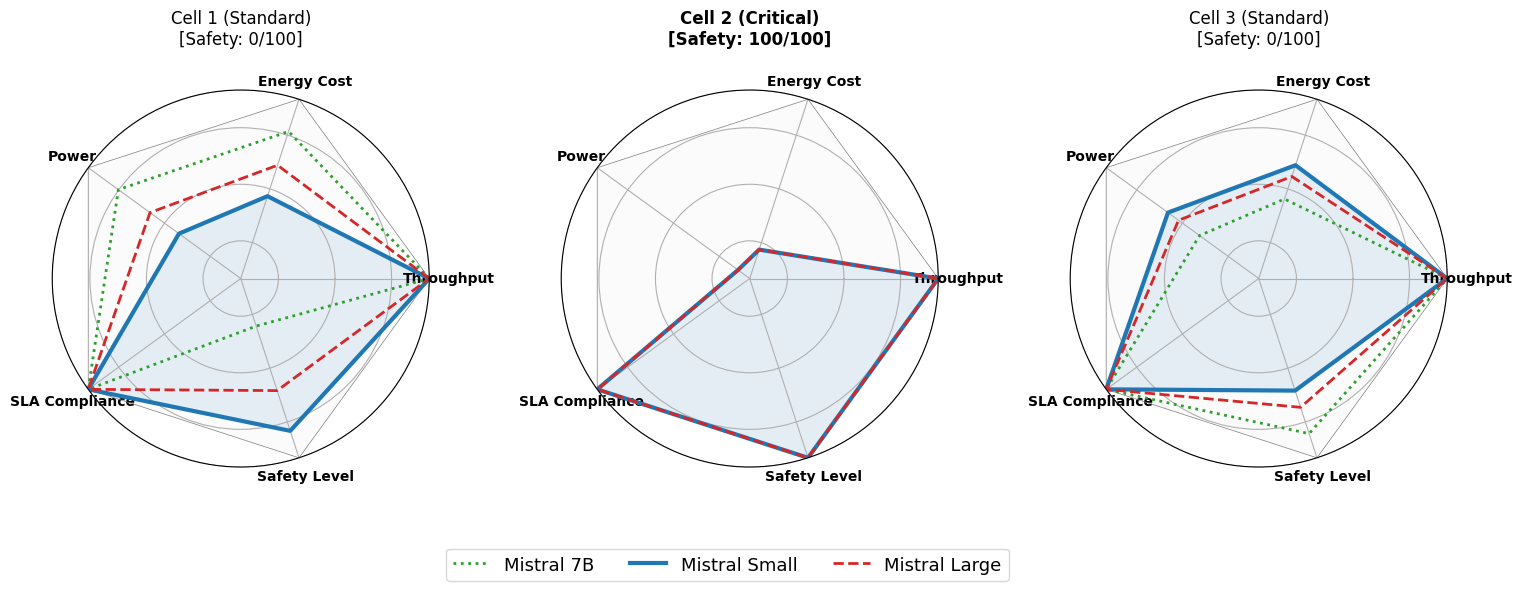

In [20]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from math import pi
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5' # <--- TUA KEY
client = Mistral(api_key=API_KEY)

MODELS_LIST = [
    "open-mistral-7b",
    "mistral-small-latest",
    "mistral-large-latest"
]

MODEL_LABELS = {
    "open-mistral-7b": "Mistral 7B",
    "mistral-small-latest": "Mistral Small",
    "mistral-large-latest": "Mistral Large"
}

USE_MOCK_LLM = False

# ==============================================================================
# 2. LOGICA MISTRAL (Log Completo)
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val, current_model):
    prompt = f"""
    Context (Step {step}, Cell {cell_id}):
    - Energy Price: {price:.2f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Safety Criticality: {safety_val:.0f}/100 (Normal=0, Emergency>80)

    Task: Output JSON weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. Emergency (>80): w_safe must be 1.0 (Ignore Price).
    2. High Price (>5) & Safe: w_eng > 0.9.
    3. Normal: Balance w_thr and w_eng.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        if safety_val > 50: return 0.0, 0.0, 1.0, prompt, '{"mock": "emergency"}'
        if price > 4.0: return 0.1, 0.9, 0.0, prompt, '{"mock": "saving"}'
        return 0.5, 0.5, 0.0, prompt, '{"mock": "normal"}'

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = client.chat.complete(model=current_model, messages=[{"role":"user", "content":prompt}])
            content = response.choices[0].message.content
            clean_json = content.replace("```json", "").replace("```", "").strip()
            if "{" in clean_json: clean_json = "{" + clean_json.split("{")[1].split("}")[0] + "}"
            d = json.loads(clean_json)
            return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0)), prompt, clean_json
        except Exception as e:
            time.sleep(1)
            continue
    return 0.7, 0.3, 0.0, prompt, "ERROR_TIMEOUT"

# ==============================================================================
# 3. AMBIENTE GYM O-RAN
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        self.bandwidth, self.noise = 100.0, 1.0
        self.max_pwr, self.min_pwr = 60.0, 5.0

    def _calculate_metrics(self, power, traffic, price):
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0)
        consumption, cost = power, power * price

        # Risk (0=Best, 1=Worst)
        risk = ((self.max_pwr - power) / (self.max_pwr - self.min_pwr))**2
        # SLA Violation (0=Best, 1=Worst)
        sla_violation = 1.0 if (throughput < 50.0 and traffic > 10.0) else 0.0

        return throughput, consumption, cost, risk, sla_violation

def optimize_power(w_thr, w_eng, w_safe, price, traffic, env):
    best_p, best_score = 5.0, -np.inf
    for p in np.linspace(5, 60, 50):
        t, cons, c, r, _ = env._calculate_metrics(p, traffic, price)
        # Normalizzazione interna per ottimizzazione
        score = (w_thr * (t/800.0)) - (w_eng * (c/600.0)) - (w_safe * r)
        if score > best_score:
            best_score, best_p = score, p
    return best_p

# ==============================================================================
# 4. ESECUZIONE SNAPSHOT STEP 26
# ==============================================================================
def run_snapshot_step_26():
    env = ORAN3CellsEnv()
    step_t = 26

    # Context (Step 26)
    price_t = 1.0 + 7.0 * np.exp(-0.3 * (step_t - 15))
    np.random.seed(42)
    traffic_step = []
    base_trend = np.linspace(40, 70, 40)
    for i in range(3):
        noise = np.random.normal(0, 5, 40)
        tr_full = np.clip(base_trend + noise, 10, 100)
        traffic_step.append(tr_full[step_t])

    safety_vals = [0.0, 100.0, 0.0]

    print(f"\n{'='*80}")
    print(f"📸 SNAPSHOT STEP 26 | Context: Price={price_t:.2f}x")
    print(f"{'='*80}")

    all_data = {}

    for model_name in MODELS_LIST:
        print(f"\n🤖 MODEL: {model_name.upper()}")
        print(f"{'-'*60}")

        all_data[model_name] = {}

        for i in range(3):
            cid = i + 1
            tr, safe = traffic_step[i], safety_vals[i]

            # LLM INTERACTION
            time.sleep(0.5)
            wa_t, wa_e, wa_s, prompt, json_resp = get_llm_weights_per_cell(step_t, cid, price_t, tr, safe, model_name)

            # --- FULL DEBUG LOG (Tutte le celle) ---
            print(f"  📍 CELL {cid} [Load: {tr:.0f}% | Safety: {safe}]")
            # print(f"     Prompt Tail: ...{prompt.strip()[-100:]}")
            print(f"     LLM Output:  {json_resp}")
            print(f"     -> Weights:  Thr={wa_t:.2f}, Eng={wa_e:.2f}, Safe={wa_s:.2f}")

            # OPTIMIZATION
            p_opt = optimize_power(wa_t, wa_e, wa_s, price_t, tr, env)
            th, cons, cost, risk, sla = env._calculate_metrics(p_opt, tr, price_t)

            print(f"     -> Action:   Power={p_opt:.1f}W")

            all_data[model_name][cid] = {
                'Throughput': th, 'Energy Cost': cost, 'Power': cons,
                'SLA Viol.': sla, 'Safety Risk': risk
            }

    return all_data

# ==============================================================================
# 5. RADAR PLOTTING (Etichette Aggiornate)
# ==============================================================================
data = run_snapshot_step_26()

# NUOVE ETICHETTE (Visivamente Positive)
# Mapping: Nome nel Grafico -> Nome nei Dati Grezzi
metric_map = {
    'Throughput': 'Throughput',
    'Energy Cost': 'Energy Cost', # Teniamo "Cost" ma visualizziamo "Efficiency" (inverso)
    'Power': 'Power',
    'SLA Compliance': 'SLA Viol.', # Invertiremo SLA Viol.
    'Safety Level': 'Safety Risk'  # Invertiremo Safety Risk
}

labels_display = list(metric_map.keys())
N = len(labels_display)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Layout con più spazio sotto per la legenda
fig, axs = plt.subplots(1, 3, figsize=(18, 7), subplot_kw={'projection': 'polar'})
plt.subplots_adjust(wspace=0.35, bottom=0.25) # <--- Spazio extra in basso

# Limiti normalizzazione
limits = {'Throughput': 110.0, 'Energy Cost': 90.0, 'Power': 65.0, 'SLA Viol.': 1.0, 'Safety Risk': 1.0}

styles = {
    "open-mistral-7b": {'color': '#2ca02c', 'ls': ':', 'lw': 2},
    "mistral-small-latest": {'color': '#1f77b4', 'ls': '-', 'lw': 3},
    "mistral-large-latest": {'color': '#d62728', 'ls': '--', 'lw': 2}
}

for i, cid in enumerate([1, 2, 3]):
    ax = axs[i]
    if cid == 2: ax.set_title(f"Cell {cid} (Critical)\n[Safety: 100/100]", weight='bold', size=12, y=1.1)
    else: ax.set_title(f"Cell {cid} (Standard)\n[Safety: 0/100]", size=12, y=1.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels_display, size=10, weight='bold') # Etichette in grassetto
    ax.set_yticks([2, 5, 8, 10])
    ax.set_yticklabels([])
    ax.set_ylim(0, 10)

    # Sfondo grigio chiaro per riferimento
    ax.fill(angles, [10]*(N+1), color="#f8f9fa", alpha=0.5)
    ax.plot(angles, [10]*(N+1), color="grey", lw=0.5)

    for model in MODELS_LIST:
        raw_vals = data[model][cid]
        scores = []

        for display_label in labels_display:
            data_key = metric_map[display_label] # Recupera la chiave dati originale
            val = raw_vals[data_key]
            lim = limits[data_key]

            # --- NORMALIZZAZIONE (10 = Migliore) ---

            if display_label == 'Throughput':
                # Higher is Better: (Val / Max) * 10
                sc = (val / lim) * 10

            elif display_label in ['SLA Compliance', 'Safety Level']:
                # Input (Viol/Risk) è "Lower is Better" (0=Ottimo, 1=Pessimo)
                # Output (Compliance/Level) deve essere "Higher is Better" (10=Ottimo)
                # Formula: (1 - Val/Max) * 10
                sc = (1.0 - (val / lim)) * 10

            else:
                # Energy Cost, Power -> Input è "Lower is Better"
                # Vogliamo che "Basso Costo" appaia come "Punteggio Alto" sul radar
                sc = (1.0 - (val / lim)) * 10

            scores.append(np.clip(sc, 0, 10))

        scores += scores[:1]
        ax.plot(angles, scores, label=MODEL_LABELS[model], **styles[model])

        # Fill solo per il nostro modello (Small) per evidenziarlo
        if "small" in model:
            ax.fill(angles, scores, color=styles[model]['color'], alpha=0.1)

# LEGENDA SPOSTATA IN BASSO
handles, labels = axs[0].get_legend_handles_labels()
# bbox_to_anchor calcolato rispetto all'intera figura grazie a transform non specificata
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.12), fontsize=13, frameon=True)

filename = "radar_chart_step26_final.pdf"
# Non usare tight_layout qui, usiamo subplots_adjust custom
plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)
print(f"\n✅ Plot Saved: {filename}")
plt.show()